In [1]:
# imports and stuff
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import torchvision
import os
from torchvision import models
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener
from torchvision.models.vgg import VGG

In [2]:
WINDOW_SIZE = (256, 256) 
STRIDE = 32 
IN_CHANNELS = 5 
FOLDER = "../input/potsdamvaihingen/" 
BATCH_SIZE = 6 
LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] 
N_CLASSES = len(LABELS) 
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

MAIN_FOLDER = FOLDER
DATA_FOLDER = MAIN_FOLDER + '3_ortho_irrg/3_Ortho_IRRG/top_potsdam_{}_IRRG.tif'
DSM_FOLDER = MAIN_FOLDER + '1_dsm/1_DSM/dsm_potsdam_0{}.tif'
NDSM_FOLDER = MAIN_FOLDER + '1_dsm_normalisation/1_DSM_normalisation/dsm_potsdam_0{}_normalized_lastools.jpg'
LABEL_FOLDER = '../input/label-all-potsdam-vaihingen/5_labels_all/top_potsdam_{}_label.tif'
ERODED_FOLDER = '../input/label-all-potsdam-vaihingen/5_labels_all_noboundary/top_potsdam_{}_label_noBoundary.tif'  

In [3]:
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

In [4]:
def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

In [5]:
class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, train_ids, dsm_ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                dsm_files=DSM_FOLDER, ndsm_files=NDSM_FOLDER,
                cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in train_ids]
        self.dsm_files = [DSM_FOLDER.format(id) for id in dsm_ids]
        self.ndsm_files = [NDSM_FOLDER.format(id) for id in dsm_ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in train_ids]
        
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 1000 samples
        return 10000
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            im = np.dstack((io.imread(self.data_files[random_idx]), io.imread(self.dsm_files[random_idx])))
            im = np.dstack((im, io.imread(self.ndsm_files[random_idx])))
            data = np.asarray(im.transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

In [6]:
class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet101(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet101Encoder(nn.Module):
    DEPTH = 6

    def __init__(self, n_classes=N_CLASSES):
        super().__init__()
        resnet = torchvision.models.resnet.resnet101(pretrained=True)
        resnet.conv1 = nn.Conv2d(IN_CHANNELS, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        down_blocks = []
        up_blocks = []
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet101(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet101(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet101(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet101(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet101(in_channels=64 + 5, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i == (UNetWithResnet101Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)

        for i, block in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet101Encoder.DEPTH - 1 - i}"
            x = block(x, pre_pools[key])
        output_feature_map = x
        x = self.out(x)
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

In [7]:
import gc
list_acc = []

from IPython.display import clear_output
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    test_images = (1/255*np.dstack((io.imread(DATA_FOLDER.format(id), dtype='float32'), io.imread(DSM_FOLDER.format(id)), 
                                 io.imread(NDSM_FOLDER.format(id)))) for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()
    c = 0
    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False):
        gc.collect()
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    #plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    #fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))
                    fig.add_subplot(1,3,3)
                    plt.imshow(gt)
                    clear_output()
                    plt.show()
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure()
        #fig.add_subplot(1,3,1)
        #plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,1)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,2)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        # Compute some metrics
        print("Result of ", test_ids[c])
        c = c + 1
        global list_acc
        list_acc.append(metrics(pred.ravel(), gt_e.ravel()))
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

In [8]:
net = UNetWithResnet101Encoder()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:02, 80820185.74it/s]


In [9]:
#import requests
#url = ''

#r = requests.get(url, allow_redirects=True)
#open('model', 'wb').write(r.content)
    
net.load_state_dict(torch.load('../input/unet101-2/Unet101_2_epoch70')['model_state_dict'])
net.cuda()

UNetWithResnet101Encoder(
  (input_block): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (input_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (down_blocks): ModuleList(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (

In [10]:
test_ids = ['2_13','2_14']
_, all_preds, all_gts = test(net, test_ids, all=True, stride=64)

Result of  2_14
Confusion matrix :
[[ 4336865    23401   438816    25836     5137   194789]
 [    5190  2273336    14122    10275    43392     8049]
 [  209889    24459 13272169   383283      223   132443]
 [  214405    39451  2242261  9641335     8259    45992]
 [    3782     6528        0     1450   147760     1054]
 [    9450    26199    10925     3979     6178    29633]]
---
33840315 pixels processed
Total accuracy : 87.76838513471284%
---
F1Score :
roads: 0.8846750319371101
buildings: 0.9576501483443274
low veg.: 0.8847888815079645
trees: 0.8663307763490841
cars: 0.7954285468194432
clutter: 0.1189306555574285
---
Kappa: 0.8177723792003299
Confusion matrix :
[[11581125   160549  1098775    71688     6810   249182]
 [   42517  8507923    71907    28460    43993    25980]
 [  548162    69839 22617914   647682     1403   196879]
 [  469034   126153  3244825 15993899    18524    94164]
 [   19018     9442      530     1880   429070    14986]
 [   76989   114769    92990    11755    262

In [11]:
print(_)
print(list_acc)

88.67084657496542
[89.59315724245366, 87.76838513471284]


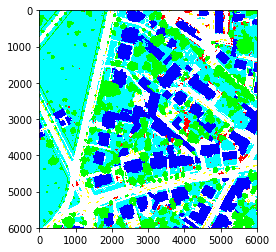

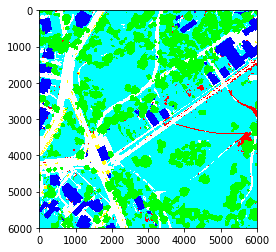

In [12]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./Unet101_inference_tile_{}.png'.format(id_), img)

del(_, all_preds, all_gts)

In [13]:
test_ids = ['3_14','4_13','4_14']
_, all_preds, all_gts = test(net, test_ids, all=True, stride=64)

Result of  4_14
Confusion matrix :
[[7389945  148814  547864   53787     928  259182]
 [  40759 6915738   20181   35778    5256   33392]
 [ 358794   56478 6412684  267188    1156  374937]
 [ 223651   27512 1309066 4709123   12132   43328]
 [  18411    2966      96    5228  587168   13242]
 [1597232  133399  586851   21059   10989 1004091]]
---
33228405 pixels processed
Total accuracy : 81.31220562648132%
---
F1Score :
roads: 0.819770050016329
buildings: 0.9648064583655802
low veg.: 0.7845231511491421
trees: 0.8249335747866663
cars: 0.94343879043013
clutter: 0.3951719402974501
---
Kappa: 0.7620552192721133
Confusion matrix :
[[23011574   344338  1326054   239507     4882   385961]
 [  153124 25835308    88719    86636    17182    77518]
 [  823352   132531 18804333   685606     1208   464903]
 [  598460   106333  3534808 14901138    30571    87753]
 [   35385    14364      214    15181  1443300    25288]
 [ 2940653   467675  1119748   121256    55688  1510078]]
---
99490629 pixels proce

In [14]:
print(_)
print(list_acc)

85.94350227698328
[89.59315724245366, 87.76838513471284, 87.27048675626826, 89.26493491477365, 81.31220562648132]


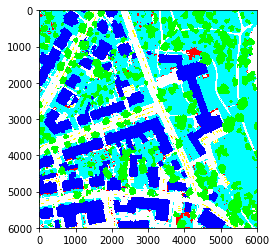

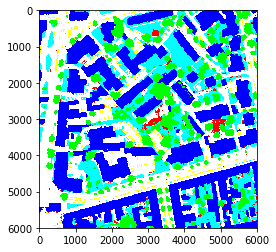

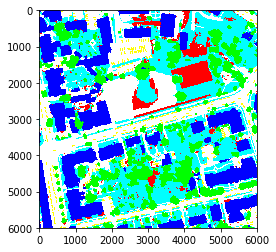

In [15]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./Unet101_inference_tile_{}.png'.format(id_), img)

del(_, all_preds, all_gts)

In [16]:
test_ids = ['4_15']
_, all_preds, all_gts = test(net, test_ids, all=True, stride=64)

Result of  4_15
Confusion matrix :
[[10397261   190834   673624    27121     2555   117466]
 [   24563 10738713    58427     8206        1    13525]
 [  225844    68406  4780304   104220      171    29378]
 [  312030    22906   849503  3005833    30192    12583]
 [   13885     2541      367     1367   597932    19957]
 [  265356   201074   160046    11716     4634   153268]]
---
33125809 pixels processed
Total accuracy : 89.57761907037501%
---
F1Score :
roads: 0.9181696235395933
buildings: 0.9732424580869896
low veg.: 0.8150148236312671
trees: 0.8133204176142629
cars: 0.9404892043783336
clutter: 0.2683566334083593
---
Kappa: 0.8569277833514163
Confusion matrix :
[[10397261   190834   673624    27121     2555   117466]
 [   24563 10738713    58427     8206        1    13525]
 [  225844    68406  4780304   104220      171    29378]
 [  312030    22906   849503  3005833    30192    12583]
 [   13885     2541      367     1367   597932    19957]
 [  265356   201074   160046    11716     46

In [17]:
print(_)
print(list_acc)

89.57761907037501
[89.59315724245366, 87.76838513471284, 87.27048675626826, 89.26493491477365, 81.31220562648132, 89.57761907037501]


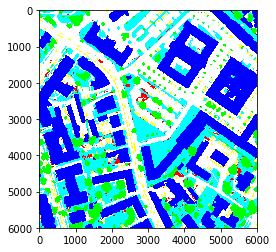

In [18]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./Unet101_inference_tile_{}.png'.format(id_), img)

del(_, all_preds, all_gts)

In [19]:
test_ids = ['5_13','5_14','5_15']
_, all_preds, all_gts = test(net, test_ids, all=True, stride=64)

Result of  5_15
Confusion matrix :
[[12212387    86241   719477   134212     3942   247247]
 [   56096  8388090    58524    33582     1999    17402]
 [   94845     4428  4131162   238398      699   112776]
 [  109290     6742   546590  3189457     7770    13194]
 [   16467     4848     1435     4905   662312    20995]
 [  441761   174222   270831    16911    16641  1257121]]
---
33302999 pixels processed
Total accuracy : 89.60312853506076%
---
F1Score :
roads: 0.9274871847995348
buildings: 0.9742115451888542
low veg.: 0.8013639140640253
trees: 0.8515996511852066
cars: 0.9432460434728428
clutter: 0.6536913365895156
---
Kappa: 0.8589049350991785
Confusion matrix :
[[30924107   200219  1447387   361425     7166   655557]
 [  229283 26932476   118724    70876     7777    53869]
 [  936921    58134 15933675   668323      958   294104]
 [  578682    58251  2324299 10856141    40190    95653]
 [   43041    15897     6422     9151  1855439    44129]
 [ 1021365   697069   779697   109922   1097

In [20]:
print(_)
print(list_acc)

88.96892994636644
[89.59315724245366, 87.76838513471284, 87.27048675626826, 89.26493491477365, 81.31220562648132, 89.57761907037501, 89.57080616059756, 87.73065415786357, 89.60312853506076]


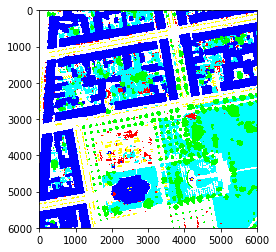

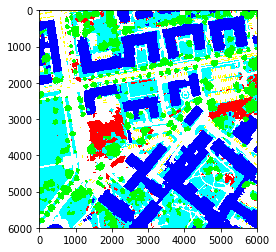

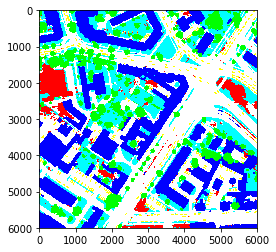

In [21]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./Unet101_inference_tile_{}.png'.format(id_), img)

del(_, all_preds, all_gts)

In [22]:
test_ids = ['6_13','6_14','6_15']
_, all_preds, all_gts = test(net, test_ids, all=True, stride=64)

Result of  6_15
Confusion matrix :
[[11259990    52198   577042    85981     1715   647232]
 [   65434  7921138    14385    10839    10520    41587]
 [   75294     2276  4365920   103588      311   117330]
 [  136781    65048  1094027  3827489    24885    35938]
 [   11279     2987      336     4019   798510     8541]
 [  177573    21159   389506    11023    26092  1355557]]
---
33343530 pixels processed
Total accuracy : 88.55872188697477%
---
F1Score :
roads: 0.9248258424495357
buildings: 0.9822407980700749
low veg.: 0.7862318661148296
trees: 0.8296184275309694
cars: 0.946267268272595
clutter: 0.6474928321425714
---
Kappa: 0.8490411247861204
Confusion matrix :
[[36006986   283310  1329406   216287     4105   789756]
 [  763663 26035813    97769    16661    22609    92487]
 [  495273    36177 16631868   336824      355   136748]
 [  587771    99844  2219915  9259354    49552    51002]
 [   22808     9258      936     5857  1943314    21451]
 [  610484   201566   800699    27642    4263

In [23]:
print(_)
print(list_acc)

90.70754315922437
[89.59315724245366, 87.76838513471284, 87.27048675626826, 89.26493491477365, 81.31220562648132, 89.57761907037501, 89.57080616059756, 87.73065415786357, 89.60312853506076, 91.81691620894432, 91.71987543242658, 88.55872188697477]


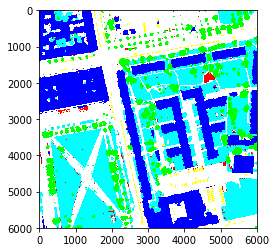

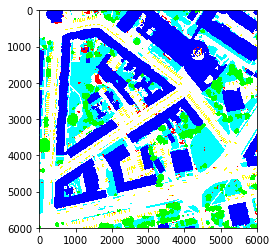

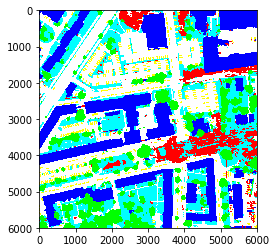

In [24]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./Unet101_inference_tile_{}.png'.format(id_), img)

del(_, all_preds, all_gts)

In [25]:
test_ids = ['7_13']
_, all_preds, all_gts = test(net, test_ids, all=True, stride=64)

Result of  7_13
Confusion matrix :
[[16193605   380957   212345   236637     4460   125461]
 [  171890  7586868    18380     5181    35392    38588]
 [  155191    22305  2864462   221216      140    35895]
 [   78584    15517   462321  1951718     2316     2615]
 [    5730     1446      286     2698   352885     4648]
 [  493974    50386   407579    16120    33633  2151997]]
---
34343426 pixels processed
Total accuracy : 90.56037391260848%
---
F1Score :
roads: 0.9455446369819095
buildings: 0.9534967749330172
low veg.: 0.7886102737913895
trees: 0.7891084070988778
cars: 0.8860680033997933
clutter: 0.7807142275389709
---
Kappa: 0.8601402010642528
Confusion matrix :
[[16193605   380957   212345   236637     4460   125461]
 [  171890  7586868    18380     5181    35392    38588]
 [  155191    22305  2864462   221216      140    35895]
 [   78584    15517   462321  1951718     2316     2615]
 [    5730     1446      286     2698   352885     4648]
 [  493974    50386   407579    16120    336

In [26]:
print(_)
print(list_acc)

90.56037391260848
[89.59315724245366, 87.76838513471284, 87.27048675626826, 89.26493491477365, 81.31220562648132, 89.57761907037501, 89.57080616059756, 87.73065415786357, 89.60312853506076, 91.81691620894432, 91.71987543242658, 88.55872188697477, 90.56037391260848]


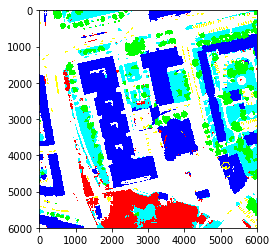

In [27]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./Unet101_inference_tile_{}.png'.format(id_), img)

del(_, all_preds, all_gts)

In [28]:
sum(list_acc)/len(list_acc)

88.79594346458005